In [73]:
import requests,os,pickle,pandas as pd, matplotlib.pyplot as plt
from bs4 import BeautifulSoup as BS
from nltk.sentiment.vader import SentimentIntensityAnalyzer

if not os.path.exists('scrapped'): os.mkdir('scrapped')

%matplotlib inline

In [74]:
def save_file(path, data):
    output = open(path, 'wb')
    pickle.dump(data, output)
    output.close()

def load_file(path):
    pkl_file  = open(path, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

In [75]:
#Get html of url
text = BS(requests.get('https://finviz.com/quote.ashx?t=PFE', headers={'User-Agent':'Mozilla/5.0'}).text)
news_headlines = text.find(id='news-table')
news_headlines

<table border="0" cellpadding="1" cellspacing="0" class="fullview-news-outer" id="news-table" width="100%">
<tr><td align="right" style="white-space:nowrap" width="130">Jan-14-22 05:38PM  </td><td align="left"><div class="news-link-container"><div class="news-link-left"><a class="tab-link-news" href="https://finance.yahoo.com/news/mraz-amerine-associates-inc-buys-223807946.html" target="_blank">Mraz, Amerine &amp; Associates, Inc. Buys Vanguard Short-Term Inflation-Protected Securities, ...</a></div><div class="news-link-right"><span style="color:#aa6dc0;font-size:9px"> GuruFocus.com</span></div></div></td></tr>
<tr><td align="right" width="130">04:14PM  </td><td align="left"><div class="news-link-container"><div class="news-link-left"><a class="tab-link-news" href="https://finance.yahoo.com/news/1-u-fda-approves-drugs-211433072.html" target="_blank">UPDATE 1-U.S. FDA approves drugs from AbbVie, Pfizer to treat eczema</a></div><div class="news-link-right"><span style="color:#aa6dc0;fon

In [76]:
saved = False

if not saved:
    data,dates = [],[]

    for news in news_headlines.findAll('tr'):
        headline = news.a.get_text()
        datetime = news.td.text.split()
        if len(datetime) == 1:
            timestamp = datetime[0]
        else:
            date = datetime[0]
            timestamp = datetime[1]
        data.append([timestamp, headline])
        dates.append(date)
    extracted = pd.DataFrame(data, columns=['Timestamp', 'Headline'])
    save_file('scrapped/extracted.pkl', extracted)
else:
    extracted = load_file('scrapped/extracted.pkl')
extracted.head()

,Timestamp,Headline
0,05:38PM,"Mraz, Amerine & Associates, Inc. Buys Vanguard..."
1,04:14PM,"UPDATE 1-U.S. FDA approves drugs from AbbVie, ..."
2,03:46PM,Omicron: 'We think that things will get better...
3,03:30PM,U.S. FDA Approves Pfizers CIBINQO® (abrocitini...
4,02:39PM,FDA approves expanded use of AbbVie's arthriti...


In [77]:
vader = SentimentIntensityAnalyzer()
sentiments = pd.DataFrame(extracted['Headline'].apply(vader.polarity_scores).tolist())
extracted = pd.concat([extracted, sentiments], axis=1).set_index(pd.Series(dates), drop=False)
extracted.head()

,Timestamp,Headline,neg,neu,pos,compound
Jan-14-22,05:38PM,"Mraz, Amerine & Associates, Inc. Buys Vanguard...",0.0,0.804,0.196,0.2960
Jan-14-22,04:14PM,"UPDATE 1-U.S. FDA approves drugs from AbbVie, ...",0.0,0.625,0.375,0.6597
Jan-14-22,03:46PM,Omicron: 'We think that things will get better...,0.0,0.870,0.130,0.2382
Jan-14-22,03:30PM,U.S. FDA Approves Pfizers CIBINQO® (abrocitini...,0.0,0.803,0.197,0.4019
Jan-14-22,02:39PM,FDA approves expanded use of AbbVie's arthriti...,0.0,0.625,0.375,0.6597


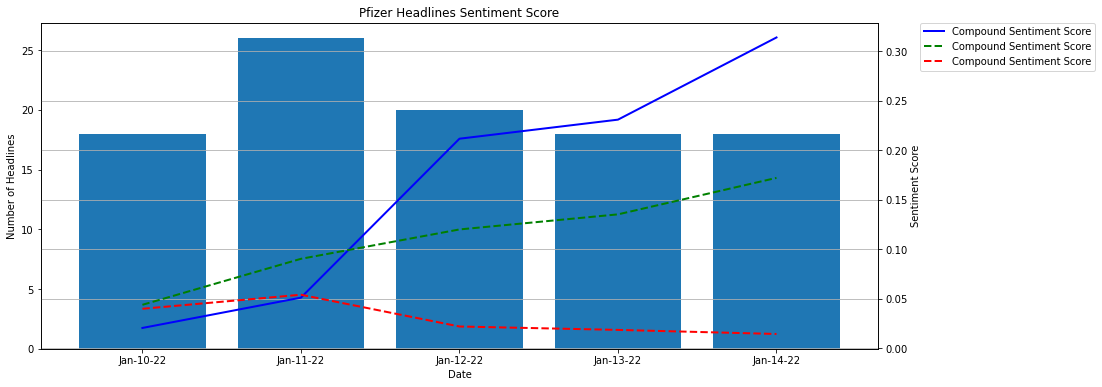

In [80]:
daily_compound = extracted.groupby(extracted.index).mean()
headline_counts = extracted.groupby(extracted.index).count()

fig,ax1 = plt.subplots(figsize=(15,6))
ax1.bar(headline_counts.index, headline_counts['Headline'])

ax2 = ax1.twinx()
ax2.plot(daily_compound.index, daily_compound['compound'],'b', label = 'Compound Sentiment Score', linewidth = 2)
ax2.plot(daily_compound.index, daily_compound['pos'], 'g--', label = 'Compound Sentiment Score', linewidth = 2)
ax2.plot(daily_compound.index, daily_compound['neg'], 'r--', label = 'Compound Sentiment Score', linewidth = 2)
ax2.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)

plt.title("Pfizer Headlines Sentiment Score")
ax1.set_ylabel("Number of Headlines")
ax2.set_ylabel("Sentiment Score")
ax1.set_xlabel("Date")
plt.grid()
plt.show()


In [ ]:
# problem is that VADER is pre trained model so may not be accurate for new data
